In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
# Implementation from HW2
# You may use np.linalg.lstsq instead

def lstsq_svd(a, b, rcond=None):
    a = np.atleast_2d(a)
    b = np.atleast_1d(b)
    u, s, vh = np.linalg.svd(a, full_matrices=False)
    if rcond is None:
        where = (s != 0.0)
    else:
        where = s > s[0] * rcond
    x = vh.T @ np.divide(u.T[:s.shape[0],:] @ b, s, out=np.zeros(a.shape[1]), where=where)
    r = a @ x - b
    cost = np.inner(r, r)
    sigma0 = cost / (b.shape[0] - x.shape[0])
    var = vh.T @ np.diag(s**(-2)) @ vh * sigma0
    
    return x, cost, var

In [3]:
def generate_ellipse(phi, width, height, size):
    x = np.vstack([width / 2 * np.cos(phi), height / 2 * np.sin(phi)]).T
    X = x + np.random.normal(0.0, 0.0125, (size,*x.shape))
    return X

In [4]:
def fit_ellipse(x, rcond=None):
    A = np.hstack([x**2,x.prod(axis=1).reshape(-1,1),x])
    cond = np.linalg.cond(A)
    ret = lstsq_svd(A, np.ones(x.shape[0]), rcond=rcond)
    # Use in case of np.linalg.lstsq  
    # cov = ret[1] / (A.shape[0] - A.shape[1]) * np.linalg.inv(A.T @ A)
    return ret + (cond,)

In [5]:
width, height = 1.25, 1.25

lim = 5.0 / 180.0 * np.pi
phi = np.linspace(-lim, lim, 4)
x = generate_ellipse(phi, width, height, 4)

In [6]:
data_set = 0

if data_set > 0:
    z = generate_ellipse(-np.pi, width, height, 4)
    x = np.hstack([x, z])

if data_set > 1:
    z = generate_ellipse(0.5 * np.pi, width, height, 4)
    x = np.hstack([x, z])

if data_set > 2:
    z = generate_ellipse(-0.5 * np.pi, width, height, 4)
    x = np.hstack([x, z])

In [7]:
def plot_ellipse():
    ellipse = Ellipse((0, 0), width=width, height=height, fill=False, edgecolor='blue', label='True curve')
    ax = plt.gca()
    ax.add_patch(ellipse)

In [8]:
def plot_curve(params):
    x = np.linspace(-1.0, 1.0, 50)
    y = np.linspace(-1.0, 1.0, 50)
    X, Y = np.meshgrid(x, y)
    A = np.dstack([X**2,Y**2,X*Y,X,Y])
    F = np.dot(A, params) - 1

    ax = plt.gca()
    ax.contour(X, Y, F, levels=[0], label="Predicted curve")

(-1, 1)

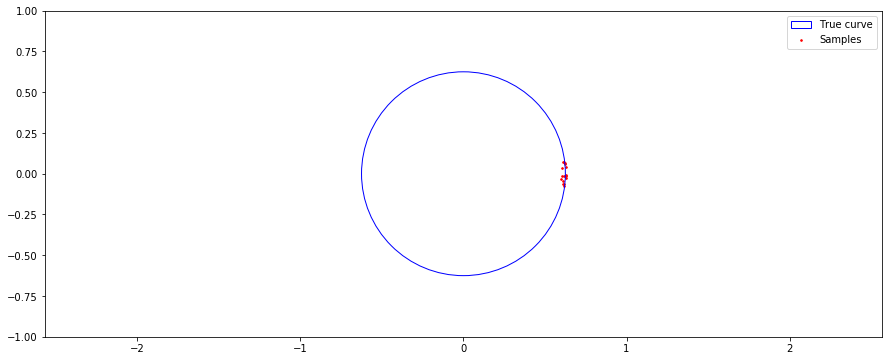

In [9]:
plt.figure(figsize=(15,6))

plt.scatter(*x.T, color='red', s=2.5, label="Samples")
plot_ellipse()
plt.axis('equal')
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1,1)

In [10]:
params, cost, cov, cond = fit_ellipse(x.reshape(-1,2))

In [11]:
cond

2761.5745502086274

/usr/lib64/python3.6/site-packages/matplotlib/contour.py:1226: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/lib64/python3.6/site-packages/matplotlib/contour.py:1006: UserWarning: The following kwargs were not used by contour: 'label'
  s)


(-1, 1)

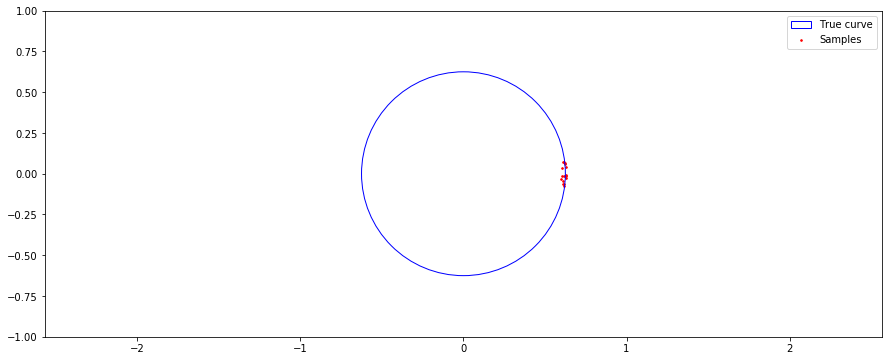

In [12]:
plt.figure(figsize=(15,6))

plt.scatter(*x.T, color='red', s=2.5, label="Samples")
plot_ellipse()
plot_curve(params)
plt.axis('equal')
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1,1)

In [13]:
sigma = np.sqrt(np.diag(cov))
cor = cov / np.outer(sigma, sigma)
cor, np.diag(cov)

(array([[ 1.        ,  0.0615029 ,  0.1884892 , -0.99971914, -0.19038402],
        [ 0.0615029 ,  1.        , -0.08836437, -0.07971332,  0.08603317],
        [ 0.1884892 , -0.08836437,  1.        , -0.19012348, -0.99994317],
        [-0.99971914, -0.07971332, -0.19012348,  1.        ,  0.19205835],
        [-0.19038402,  0.08603317, -0.99994317,  0.19205835,  1.        ]]),
 array([1.20856958e-04, 1.08019073e-03, 3.97529024e-02, 4.61573582e-05,
        1.51048936e-02]))

<Figure size 1080x432 with 0 Axes>

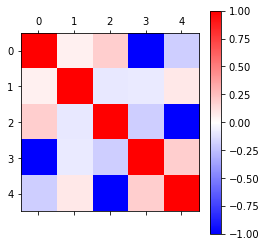

In [14]:
plt.figure(figsize=(15,6))
plt.matshow(cor, vmin=-1.0, vmax=1.0, cmap='bwr')
plt.colorbar()

In [15]:
params, cost, cov, cond = fit_ellipse(x.reshape(-1,2), rcond=0.01)

In [16]:
cond

2761.5745502086274

(-1, 1)

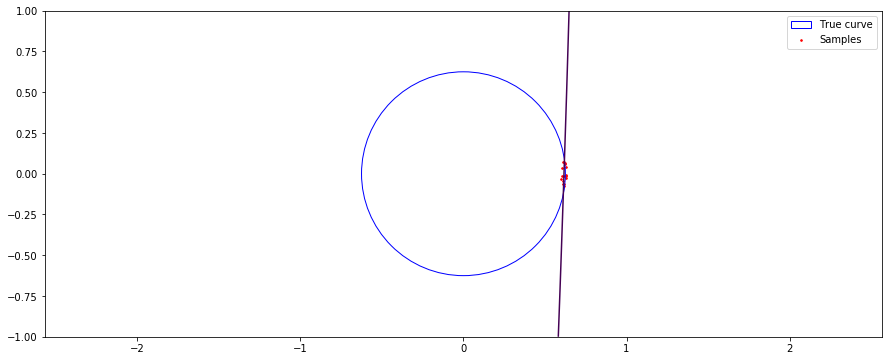

In [17]:
plt.figure(figsize=(15,6))

plt.scatter(*x.T, color='red', s=2.5, label="Samples")
plot_ellipse()
plot_curve(params)
plt.axis('equal')
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1,1)

### Делаем замену переменных.

Старая модель:

$$a_1 x^2 + a_2 y^2 + a_3 x y + a_4 x + a_5 y = 1$$

Нам бы хотелось, чтобы псевдорешение (т.е. вектор $\bf{a}$ с минимальной нормой) было похоже на нужный нам геометрический объект.

$$a_1 \approx \left({\frac{2}{W}}\right)^2$$
$$a_2 \approx \left({\frac{2}{H}}\right)^2$$
$$a_3 = a_4 = a_5 \approx 0$$

Сделаем замену переменных 

$$b_1 = a_1 - \left({\frac{2}{W}}\right)^2$$
$$b_2 = a_2 - \left({\frac{2}{H}}\right)^2$$
$$b_3 = a_3$$
$$b_4 = a_4$$
$$b_5 = a_5$$

Тогда новая модель:

$$b_1 x^2 + b_2 y^2 + b_3 x y + b_4 x + b_5 y = 1 - x^2 \left({\frac{2}{W}}\right)^2 - y^2 \left({\frac{2}{H}}\right)^2$$

In [18]:
def fit_ellipse_2(x, rcond=None):
    A = np.hstack([x**2,x.prod(axis=1).reshape(-1,1),x])
    cond = np.linalg.cond(A)
    c = np.asarray([width, height])
    ret = lstsq_svd(A, np.ones(x.shape[0]) - np.sum((2*x/c)**2, axis=1), rcond=rcond)
    # Use in case of np.linalg.lstsq  
    # cov = ret[1] / (A.shape[0] - A.shape[1]) * np.linalg.inv(A.T @ A)
    return ret + (cond,)

In [19]:
def plot_curve_2(params):
    x = np.linspace(-1.0, 1.0, 50)
    y = np.linspace(-1.0, 1.0, 50)
    X, Y = np.meshgrid(x, y)
    A = np.dstack([X**2,Y**2,X*Y,X,Y])
    F = np.dot(A, params) - (1 - (2*X/width)**2 - (2*Y/height)**2)

    ax = plt.gca()
    ax.contour(X, Y, F, levels=[0], label="Predicted curve")

In [20]:
# Try with rcond = None

params, cost, cov, cond = fit_ellipse_2(x.reshape(-1,2), rcond=0.01)

In [21]:
params

array([ 0.01348549, -0.00066221, -0.05660598,  0.02487061, -0.09185163])

(-1, 1)

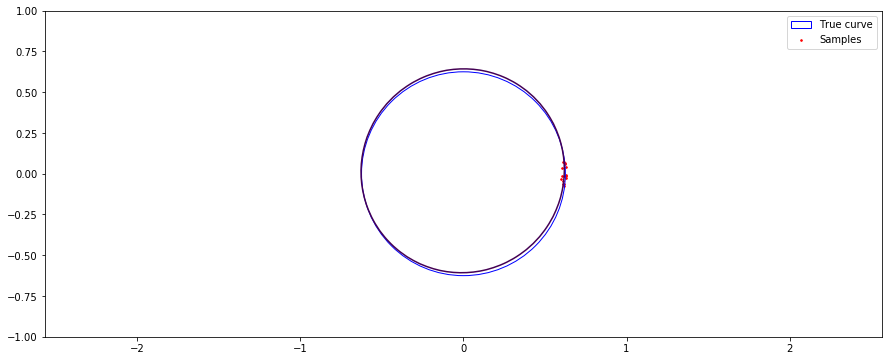

In [22]:
plt.figure(figsize=(15,6))

plt.scatter(*x.T, color='red', s=2.5, label="Samples")
plot_ellipse()
plot_curve_2(params)
plt.axis('equal')
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1,1)

In [23]:
sigma = np.sqrt(np.diag(cov))
cor = cov / np.outer(sigma, sigma)
cor, np.diag(cov)

(array([[ 1.        ,  0.0615029 ,  0.1884892 , -0.99971914, -0.19038402],
        [ 0.0615029 ,  1.        , -0.08836437, -0.07971332,  0.08603317],
        [ 0.1884892 , -0.08836437,  1.        , -0.19012348, -0.99994317],
        [-0.99971914, -0.07971332, -0.19012348,  1.        ,  0.19205835],
        [-0.19038402,  0.08603317, -0.99994317,  0.19205835,  1.        ]]),
 array([  2.59888991,  23.22825966, 854.84045927,   0.99256092,
        324.81336899]))

<Figure size 1080x432 with 0 Axes>

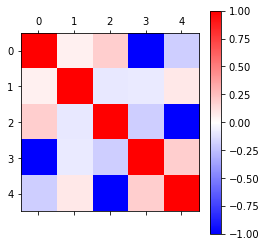

In [24]:
plt.figure(figsize=(15,6))
plt.matshow(cor, vmin=-1.0, vmax=1.0, cmap='bwr')
plt.colorbar()